# Example 8: RVT SRA with simulated profiles

Use RVT with simulated profiles to compute the surface response spectrum and surface spectral ratio.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
m = pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna")
m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.ToroVelocityVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
for p in pystrata.variation.iter_varied_profiles(
    profile,
    count,
    var_thickness=var_thickness,
    var_velocity=var_velocity,
    var_soiltypes=var_soiltypes,
):
    # Here we auto-descretize the profile for wave propagation purposes
    calc(m, p.auto_discretize(), p.location("outcrop", index=-1))
    outputs(calc)

## Plot the outputs

Create a few plots of the output.

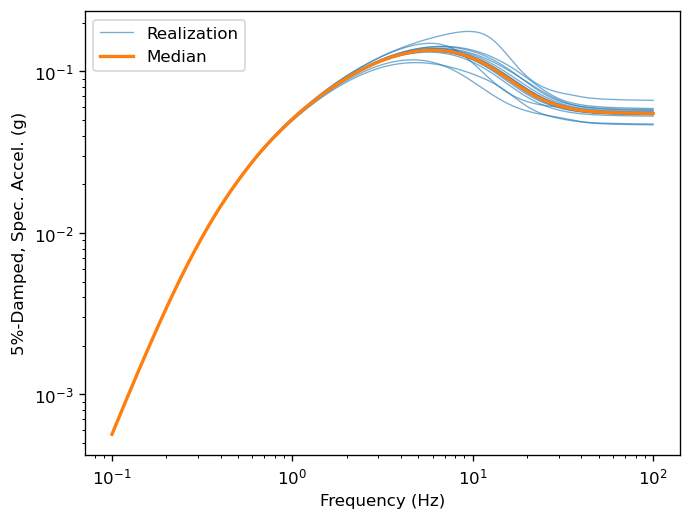

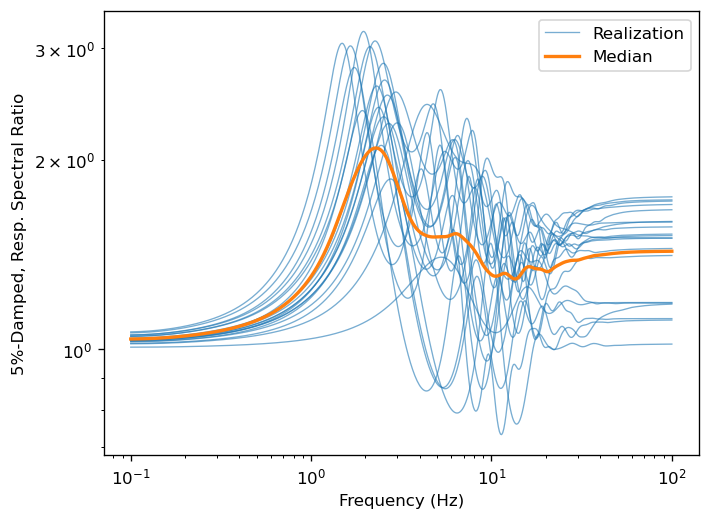

In [9]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

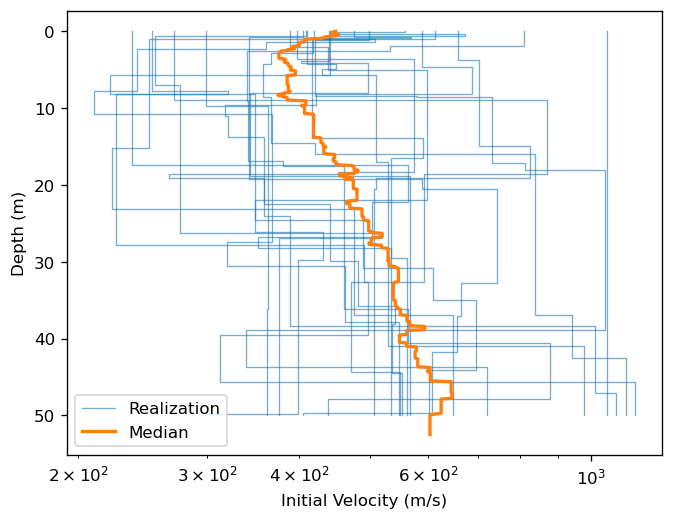

In [10]:
ax = outputs[-1].plot(style="stats")

The statistics of the output can be also retrieved and returned as either a `dict` or `pandas.DataFrame`.

In [11]:
outputs[-1].calc_stats()

{'ref': array([ 0.        ,  0.10273973,  0.20547945,  0.30821918,  0.4109589 ,
         0.51369863,  0.61643836,  0.71917808,  0.82191781,  0.92465753,
         1.02739726,  1.13013699,  1.23287671,  1.33561644,  1.43835616,
         1.54109589,  1.64383562,  1.74657534,  1.84931507,  1.95205479,
         2.05479452,  2.15753425,  2.26027397,  2.3630137 ,  2.46575342,
         2.56849315,  2.67123288,  2.7739726 ,  2.87671233,  2.97945205,
         3.08219178,  3.18493151,  3.28767123,  3.39041096,  3.49315068,
         3.59589041,  3.69863014,  3.80136986,  3.90410959,  4.00684932,
         4.10958904,  4.21232877,  4.31506849,  4.41780822,  4.52054795,
         4.62328767,  4.7260274 ,  4.82876712,  4.93150685,  5.03424658,
         5.1369863 ,  5.23972603,  5.34246575,  5.44520548,  5.54794521,
         5.65068493,  5.75342466,  5.85616438,  5.95890411,  6.06164384,
         6.16438356,  6.26712329,  6.36986301,  6.47260274,  6.57534247,
         6.67808219,  6.78082192,  6.8835616

In [12]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,448.722087,0.366195
0.102740,444.019217,0.362781
0.205479,444.019217,0.362781
0.308219,444.019217,0.362781
0.410959,452.970890,0.374031
...,...,...
52.089041,602.983198,0.389859
52.191781,602.983198,0.389859
52.294521,602.983198,0.389859


## Repeat using a Generic Depth-Dependent Model

The generic `DepthDependToroVelVariation` follows the SPID guidance.

In [13]:
var_velocity_dd = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")

In [14]:
outputs.reset()
count = 20
for p in pystrata.variation.iter_varied_profiles(
    profile,
    count,
    var_thickness=var_thickness,
    var_velocity=var_velocity_dd,
    var_soiltypes=var_soiltypes,
):
    calc(m, p.auto_discretize(), p.location("outcrop", index=-1))
    outputs(calc)

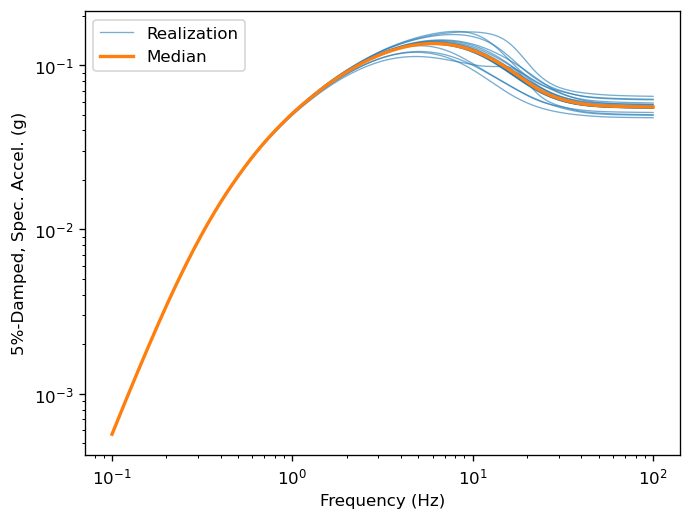

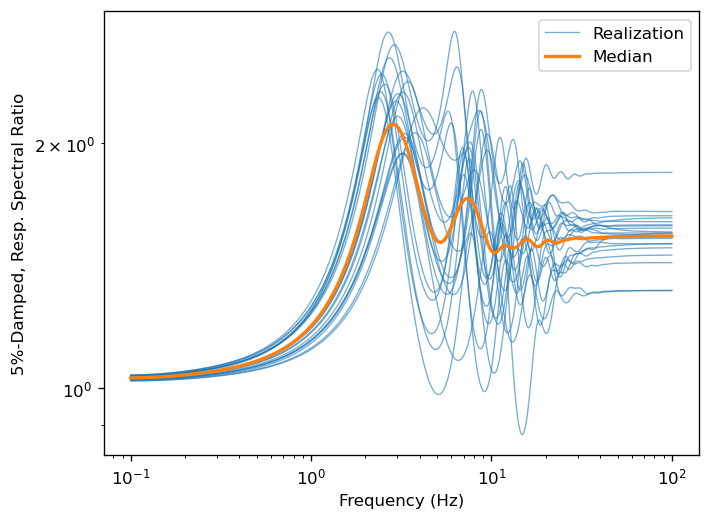

In [15]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

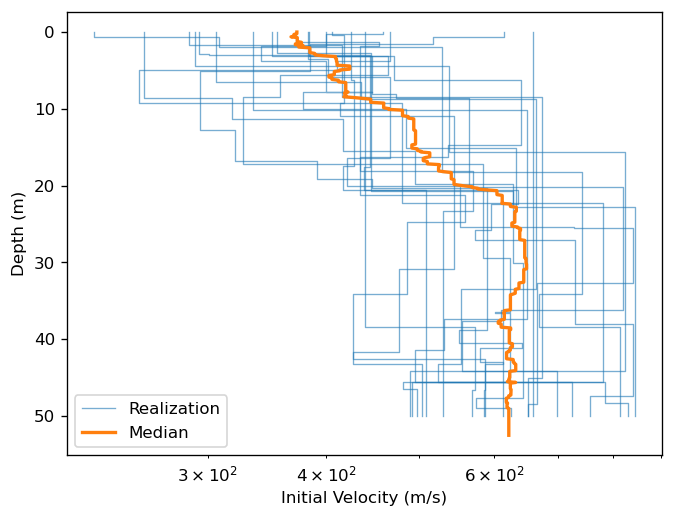

In [16]:
ax = outputs[-1].plot(style="stats")

In [17]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,372.385840,0.259978
0.102740,372.385840,0.259978
0.205479,372.385840,0.259978
0.308219,369.794239,0.256107
0.410959,370.342020,0.256723
...,...,...
52.089041,622.081125,0.175702
52.191781,622.081125,0.175702
52.294521,622.081125,0.175702


## Repeat using a Specific Depth-Dependent Model

In [18]:
var_velocity_dd = pystrata.variation.DepthDependToroVelVariation.generic_model(
    "USGS C", depth=[0, 10, 20], ln_std=[0.25, 0.15, 0.10]
)

In [19]:
outputs.reset()
count = 20
for p in pystrata.variation.iter_varied_profiles(
    profile,
    count,
    var_thickness=var_thickness,
    var_velocity=var_velocity_dd,
    var_soiltypes=var_soiltypes,
):
    calc(m, p.auto_discretize(), p.location("outcrop", index=-1))
    outputs(calc)

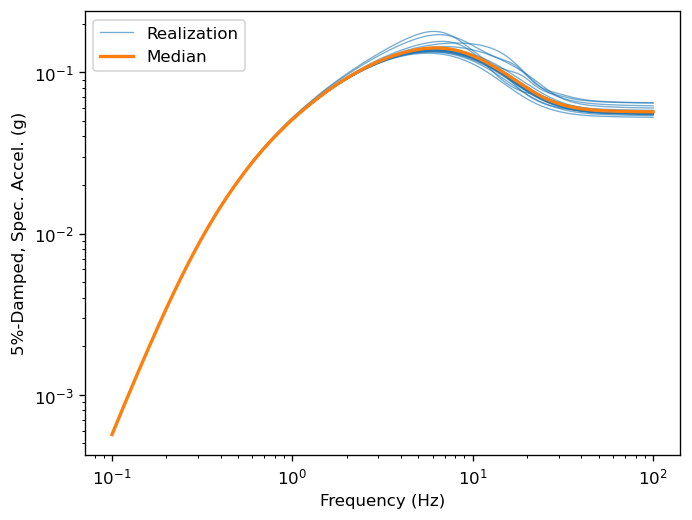

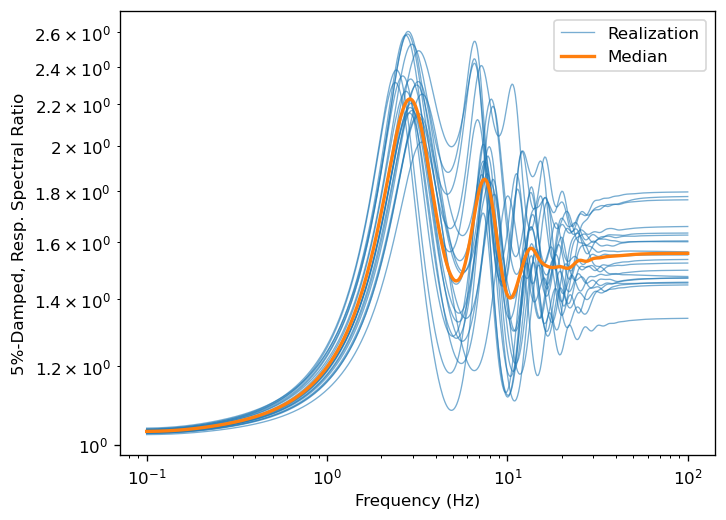

In [20]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

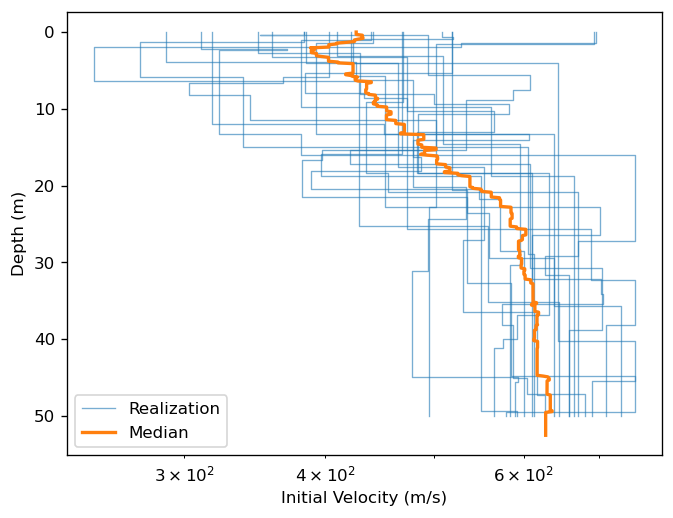

In [21]:
ax = outputs[-1].plot(style="stats")

In [22]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,426.184731,0.229072
0.102740,426.184731,0.229072
0.205479,426.184731,0.229072
0.308219,426.184731,0.229072
0.410959,431.617421,0.229810
...,...,...
52.089041,627.788558,0.088937
52.191781,627.788558,0.088937
52.294521,627.788558,0.088937
